<a href="https://colab.research.google.com/github/SoungbinC/CMPE_258/blob/assignment3/Assignment4_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision object detection task

## Vision object detection task

Kaggle Jsone is required to run this google colab

### Load and prepare the dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d anirudhg15/bears-fastai-2021

bears-fastai-2021.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -qo bears-fastai-2021.zip

In [5]:
from fastai.vision.all import *
from pathlib import Path
path = Path('/content/bears')
path.ls()

(#3) [Path('/content/bears/teddy'),Path('/content/bears/black'),Path('/content/bears/grizzly')]

In [6]:
def get_dls(bs, size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y = parent_label,
                       splitter = RandomSplitter(),
                       item_tfms = Resize(size)
                      )
    return dblock.dataloaders(path, bs = bs)

In [7]:
dls = get_dls(16, 128)

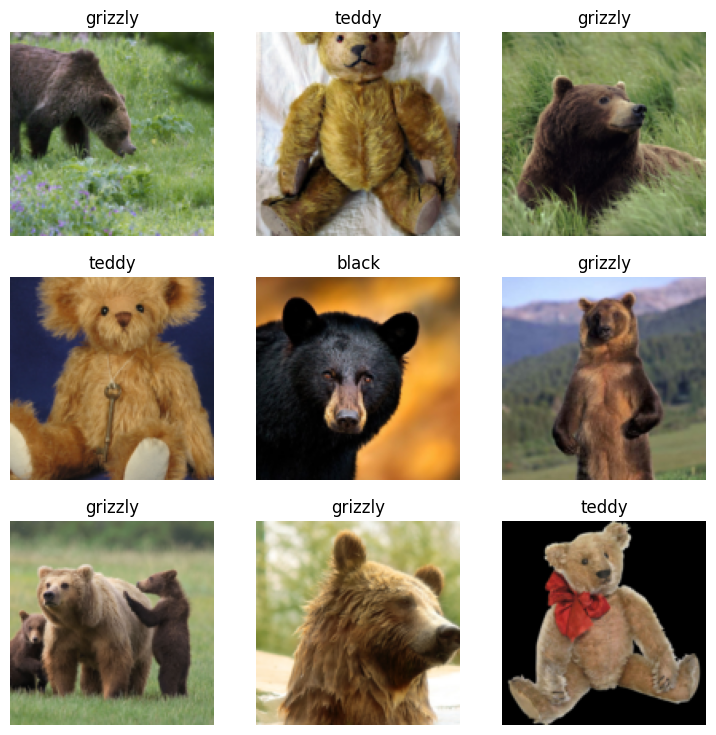

In [8]:
dls.show_batch()

### Train a model

In [9]:

learn = vision_learner(dls, resnet34, metrics=error_rate)


SuggestedLRs(valley=0.0008317637839354575)

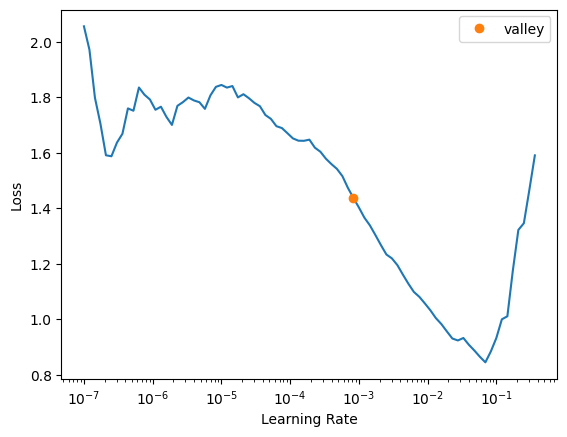

In [10]:
learn.lr_find()

In [11]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.875066,0.486709,0.789474,00:07
1,1.187712,0.079785,0.982456,00:06
2,0.762797,0.042509,0.964912,00:06
3,0.551159,0.058391,0.964912,00:06
4,0.415484,0.053589,0.964912,00:06
5,0.298840,0.038375,0.982456,00:07
6,0.238779,0.028242,1.000000,00:07
7,0.190457,0.036090,0.982456,00:07
8,0.158004,0.033580,0.982456,00:07
9,0.129686,0.040659,0.964912,00:07


In [12]:
learn.dls = get_dls(16, 224)
learn.fine_tune(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.045191,0.050536,0.964912,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.053779,0.067734,0.982456,00:07
1,0.068280,0.058528,0.982456,00:06
2,0.053290,0.109397,0.964912,00:07
3,0.042699,0.183897,0.964912,00:07
4,0.034504,0.161239,0.964912,00:06


### The result and Inference

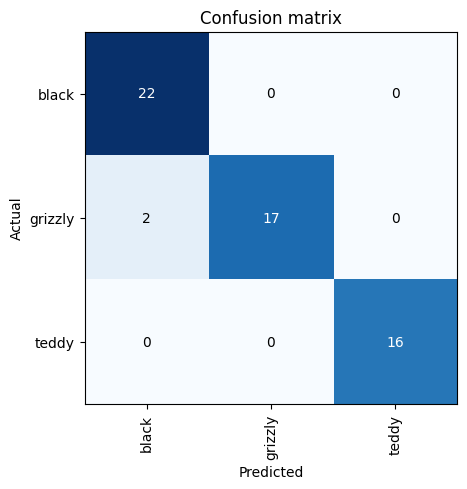

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

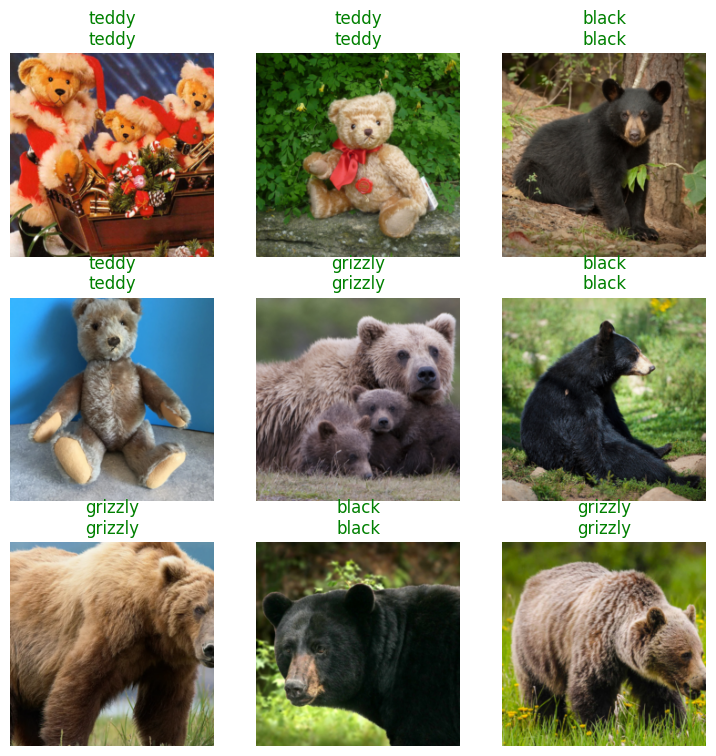

In [14]:
learn.show_results()

### Save the model

In [15]:
import os

models_dir = '/content/models'
os.makedirs(models_dir, exist_ok=True)
learn.export(f'{models_dir}/model_1.pkl')

### Reload the model

In [16]:
from fastai.learner import load_learner

# Path to your models directory
models_dir = '/content/models'

# Loading the models
model_1 = load_learner(f'{models_dir}/model_1.pkl')
model_1

### Predict with the model

In [17]:
model_1.predict('/content/bears/black/00000017.jpg')

('black', tensor(0), tensor([9.9953e-01, 3.6682e-04, 9.9338e-05]))

## Vision Segmentation Task

### Load and prepare the dataset

In [18]:
def label_func(o):
    return path/'labels'/f'{o.stem}_P{o.suffix}'

path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=get_image_files(path/"images"),
    label_func=label_func,
    codes=np.loadtxt(path/'codes.txt', dtype=str)
)

### Train a model


In [19]:
learn2 = unet_learner(dls, resnet34)
learn2.fine_tune(8)


epoch,train_loss,valid_loss,time
0,2.955320,2.495130,00:02


epoch,train_loss,valid_loss,time
0,1.958515,1.556491,00:02
1,1.664701,1.232787,00:02
2,1.436851,1.032989,00:02
3,1.285942,0.891189,00:02
4,1.149417,0.770791,00:02
5,1.036364,0.707220,00:02
6,0.943660,0.689238,00:02
7,0.871947,0.688875,00:02


### Inference and result metrics

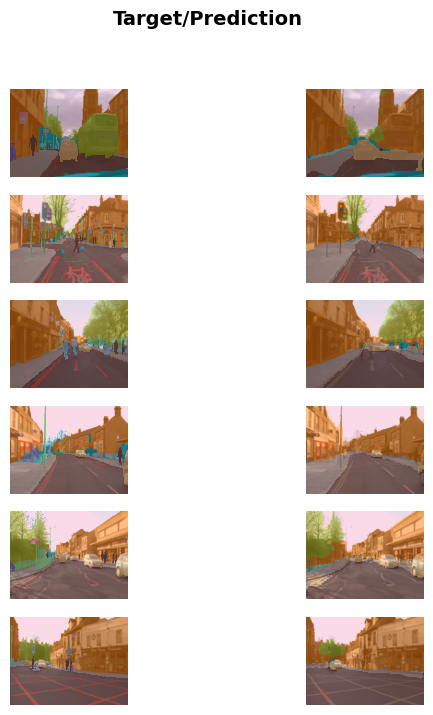

In [20]:
learn2.show_results(max_n=6, figsize=(7,8))


### Save the model

In [21]:
import os

models_dir = '/content/models'
os.makedirs(models_dir, exist_ok=True)

In [22]:
learn2.export(f'{models_dir}/model_2.pkl')

### Reload the model

In [23]:
model_2 = load_learner(f'{models_dir}/model_2.pkl')
model_2

## tabular task

### Load and prepare the dataset

In [24]:
!kaggle datasets download -d shubhamgupta012/titanic-dataset

titanic-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [25]:
!unzip -qo titanic-dataset.zip

In [26]:
import pandas as pd
from fastai.tabular.all import *


df = pd.read_csv('/content/SVMtrain.csv')

# Replace 'Sex', 'Ticket', 'Cabin', 'Embarked', etc., with the actual categorical and continuous columns from your CSV
cat_names = ['Sex',  'Embarked']  # Update these based on your dataset's columns
cont_names = ['Age', 'SibSp', 'Parch', 'Fare']  # Update these based on your dataset's columns

procs = [Categorify, FillMissing, Normalize]

dls = TabularDataLoaders.from_df(df, y_names="Survived",
                                 cat_names=cat_names,
                                 cont_names=cont_names,
                                 procs=procs)

### Train a model

In [27]:
learn3 = tabular_learner(dls, metrics=accuracy)
learn3.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.623999,0.461471,0.570621,00:00
1,0.509917,0.411985,0.570621,00:00
2,0.443018,0.379968,0.570621,00:00


### Inference and result metrics

In [28]:
learn3.show_results()

,Sex,Embarked,Age,SibSp,Parch,Fare,Survived,Survived_pred
0,1.0,3.0,-0.461495,-0.471135,0.808620,0.029115,0.0,0.085161
1,2.0,1.0,0.109079,0.393422,-0.462324,0.780043,1.0,0.296147
2,2.0,3.0,-0.803839,-0.471135,-0.462324,-0.475972,1.0,0.058214
3,2.0,2.0,1.364341,-0.471135,-0.462324,-0.466410,1.0,-0.077838
4,2.0,3.0,-1.602642,2.122535,0.808620,-0.204794,0.0,-0.093929
5,1.0,3.0,-0.917953,-0.471135,-0.462324,-0.464121,0.0,0.034066
6,1.0,3.0,1.364341,-0.471135,-0.462324,-0.618181,0.0,-0.076764
7,1.0,3.0,-0.233265,-0.471135,-0.462324,-0.464121,1.0,0.111689
8,1.0,1.0,-0.917953,-0.471135,-0.462324,-0.476380,1.0,0.031439


### Save the model

In [29]:
learn3.export(f'{models_dir}/model_3.pkl')

### Reload the model

In [30]:
model_3 = load_learner(f'{models_dir}/model_3.pkl')
model_3

## Recommendation Task

### Load and prepare the dataset

In [31]:
!kaggle datasets download -d sripaadsrinivasan/yelp-coffee-reviews

yelp-coffee-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!unzip -qo yelp-coffee-reviews.zip

In [33]:
# Attempt to load the dataset with a different encoding
try:
    # Trying with ISO-8859-1 encoding
    ratings_data = pd.read_csv('/content/ratings_and_sentiments.csv', encoding='ISO-8859-1')
except Exception as e:
    print(f"Error with ISO-8859-1 encoding: {e}")

    # Trying with replacement for problematic characters
    ratings_data = pd.read_csv('/content/ratings_and_sentiments.csv', encoding='utf-8', errors='replace')

# Display the first few rows of the dataset
ratings_data.head()

,coffee_shop_name,review_text,rating,num_rating,cat_rating,bool_HIGH,overall_sent,vibe_sent,tea_sent,service_sent,seating_sent,price_sent,parking_sent,location_sent,alcohol_sent,coffee_sent,food_sent,hours_sent,internet_sent,local_sent
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the vibe! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha coffee, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to alcohol, desired level of sweetness, and a checkout system. I got my coffee within minutes! I was hoping for a typical heart or feather on my coffee, but found myself listing out all the possibilities of what the vibe may be. Any ideas?",5.0 star rating,5.0,HIGH,1.0,4.0,3,0.0,0.0,0.0,0.0,0,0.0,1.0,3,0,0.0,0.0,0.0
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, vibe in Austin BEAUTIFUL!!!! Love the vibe! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) food food was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4.0 star rating,4.0,HIGH,1.0,3.0,3,0.0,0.0,0.0,0.0,0,0.0,0.0,0,2,0.0,0.0,0.0
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in food seating I loved the eclectic and homey plush vibe and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make food so we headed out in search of food and foods. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seating and they will call your name when your items are ready. Be patient because some of the coffee drinks take longer than others. I had the cold coffee coffee, food and foods and we shared...",4.0 star rating,4.0,HIGH,1.0,2.0,2,0.0,0.0,3.0,0.0,0,0.0,0.0,-1,2,0.0,0.0,0.0
3,The Factory - Cafe With a Soul,11/25/2016 Very cool vibe! Good drinks Nice seating However... Just about everything is bad price. $1.50 extra for 3 ounces of Almond Milk in a coffee. No WiFi vibe is a bit loud and the mix is odd. Pleasant French oldies followed by loud techno. Several seatings were dirty when we got there. Service is average. It feels like a Los Angeles coffee shot that is out of place.,2.0 star rating,2.0,LOW,0.0,1.0,0,0.0,0.0,-1.0,-1.0,0,0.0,0.0,0,0,0.0,0.0,0.0
4,The Factory - Cafe With a Soul,"12/3/2016 1 check-in They are location within the Northcross mall shopping center facing east toward Burnet Rd with plenty of parking. I loved their computerized user friendly ordering system, it made it easy me to pick & choose all the items I wanted to try. I ordered pop tart, food & foods, strawberry foods (photos uploaded). This place is ideal for ordering a few dishes to share with your group. seatinging is limited since this place is fairly new with lots of visitors. Arrive early and be prepared to wait a bit if you with a large grop. Store front facing Burnet Rd See all photos from...",4.0 star rating,4.0,HIGH,1.0,2.0,0,0.0,0.0,0.0,0.0,3,0.0,0.0,0,0,0.0,0.0,0.0


In [34]:
# Create a unique user ID based on the review text (not ideal, but for demonstration purposes)
ratings_data['user_id'] = ratings_data['review_text'].astype('category').cat.codes

# Check the new DataFrame structure
ratings_data= ratings_data[['user_id', 'coffee_shop_name', 'num_rating']].copy()
ratings_data.head()

,user_id,coffee_shop_name,num_rating
0,1549,The Factory - Cafe With a Soul,5.0
1,1955,The Factory - Cafe With a Soul,4.0
2,1667,The Factory - Cafe With a Soul,4.0
3,1557,The Factory - Cafe With a Soul,2.0
4,2081,The Factory - Cafe With a Soul,4.0


In [35]:
print(ratings_data.isnull().sum())

user_id             0
coffee_shop_name    5
num_rating          5
dtype: int64


In [36]:
ratings_data.dropna(inplace=True)

In [37]:
from fastai.collab import *

# Create a DataLoaders object
dls = CollabDataLoaders.from_df(ratings_data, user_name='user_id', item_name='coffee_shop_name', rating_name='num_rating', bs=64)



### Train a model

In [38]:
# Train the collaborative filtering model
learn4 = collab_learner(dls, n_factors=50, y_range=(1, 5))
learn4.fine_tune(5)

epoch,train_loss,valid_loss,time
0,2.409788,2.389868,00:00


epoch,train_loss,valid_loss,time
0,2.274757,2.326568,00:00
1,2.122221,2.174533,00:00
2,1.838925,2.048184,00:00
3,1.598925,1.990426,00:00
4,1.471270,1.981376,00:00


### Inference and result metrics

In [39]:
learn4.show_results()

,user_id,coffee_shop_name,num_rating,num_rating_pred
0,0.0,18.0,5.0,3.139807
1,0.0,45.0,5.0,3.178608
2,0.0,68.0,5.0,3.173388
3,0.0,25.0,5.0,3.204192
4,5160.0,29.0,3.0,2.984932
5,0.0,41.0,5.0,3.214895
6,1176.0,69.0,3.0,2.999853
7,0.0,31.0,5.0,3.190252
8,0.0,20.0,5.0,3.210632


### Save the model

In [40]:
learn4.export(f'{models_dir}/model_4.pkl')

### Reload the model

In [41]:
model_4 = load_learner(f'{models_dir}/model_4.pkl')
model_4